<a href="https://colab.research.google.com/github/black-blip/weather-classification/blob/main/WeatherClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Weather** **Classification**



In [1]:
import os
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

Extracting the Dataset

In [ ]:
import zipfile
local_zip = 'dataset2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()


In [10]:
base_dir = 'dataset2'
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

#training weather pictures
train_rise_dir = os.path.join(train_dir, 'sunrise')
train_shine_dir = os.path.join(train_dir, 'shine')
train_rain_dir = os.path.join(train_dir, 'rain')
train_cloudy_dir = os.path.join(train_dir, 'cloudy')

#Validation pictures
validation_rise_dir = os.path.join(validation_dir, 'sunrise')
validation_shine_dir = os.path.join(validation_dir, 'sunshine')
validation_rain_dir = os.path.join(validation_dir,'rain')
validation_cloudy_dir = os.path.join(validation_dir,'cloudy')



Preprocessing


In [8]:
try:
  os.mkdir('dataset2/training')
  os.mkdir('dataset2/training/sunrise')
  os.mkdir('dataset2/training/cloudy')
  os.mkdir('dataset2/training/rain')
  os.mkdir('dataset2/training/shine')
  os.mkdir('dataset2/validation')
  os.mkdir('dataset2/validation/sunrise')
  os.mkdir('dataset2/validation/cloudy')
  os.mkdir('dataset2/validation/rain')
  os.mkdir('dataset2/validation/shine')

except OSError:
  pass

In [9]:
import random
from shutil import copyfile


def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


SUNRISE_SOURCE_DIR = "dataset2/Sunrise/"
TRAINING_SUNRISE_DIR = "dataset2/training/sunrise/"
TESTING_SUNRISE_DIR = "dataset2/validation/sunrise/"
SHINE_SOURCE_DIR = "dataset2/Shine/"
TRAINING_SHINE_DIR = "dataset2/training/shine/"
TESTING_SHINE_DIR = "dataset2/validation/shine/"
RAIN_SOURCE_DIR = "dataset2/Rain/"
TRAINING_RAIN_DIR = "dataset2/training/rain/"
TESTING_RAIN_DIR = "dataset2/validation/rain/"
CLOUDY_SOURCE_DIR = "dataset2/Cloudy/"
TRAINING_CLOUDY_DIR = "dataset2/training/cloudy/"
TESTING_CLOUDY_DIR = "dataset2/validation/cloudy/"


split_size = .9
split_data(SUNRISE_SOURCE_DIR, TRAINING_SUNRISE_DIR, TESTING_SUNRISE_DIR, split_size)
split_data(SHINE_SOURCE_DIR, TRAINING_SHINE_DIR, TESTING_SHINE_DIR, split_size)
split_data(RAIN_SOURCE_DIR, TRAINING_RAIN_DIR, TESTING_RAIN_DIR, split_size)
split_data(CLOUDY_SOURCE_DIR, TRAINING_CLOUDY_DIR, TESTING_CLOUDY_DIR, split_size)


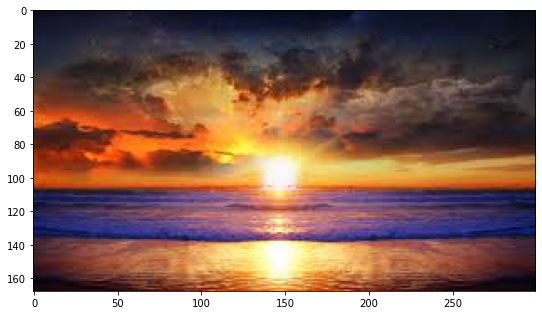

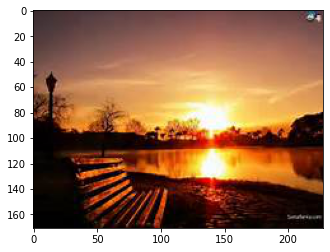

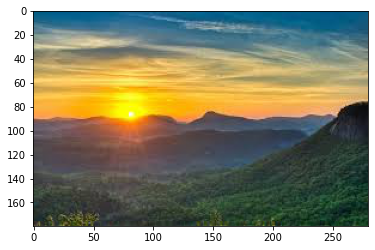

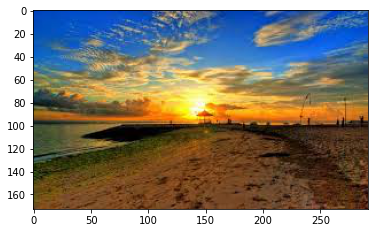

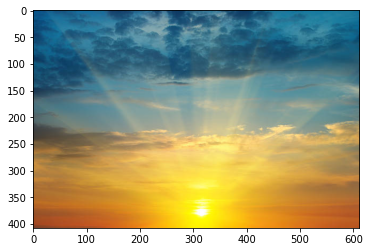

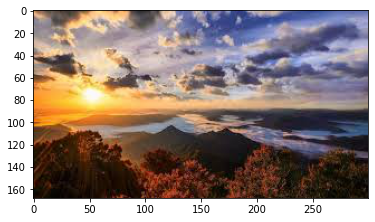

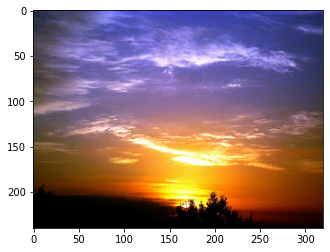

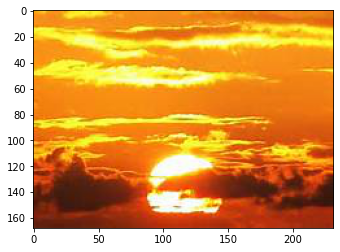

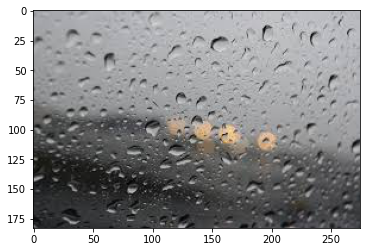

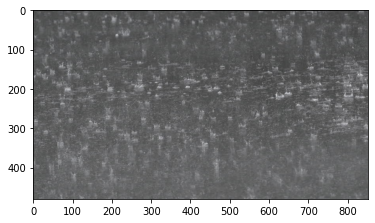

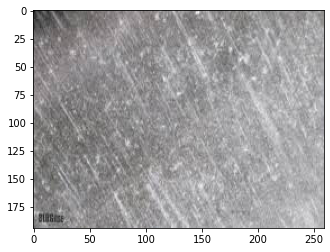

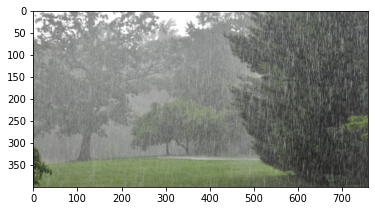

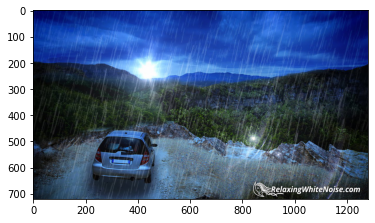

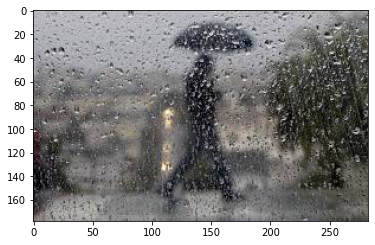

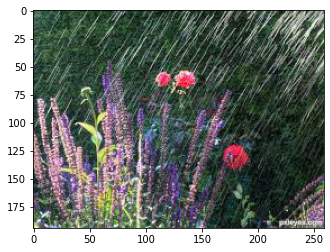

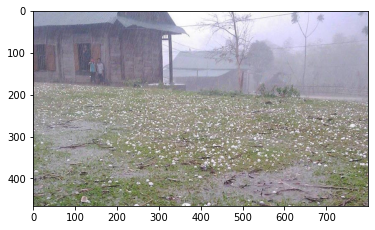

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

rows, cols = 3,3
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(cols * 3, rows * 3)

train_rise_names = os.listdir(train_rise_dir)
train_shine_names = os.listdir(train_shine_dir)
train_rain_names  = os.listdir(train_rain_dir)
train_cloudy_names = os.listdir(train_cloudy_dir)

pic_index += 8
next_rise_pix = [os.path.join(train_rise_dir, fname) 
                for fname in train_rise_names[pic_index-8:pic_index]]
next_shine_pix = [os.path.join(train_shine_dir, fname) 
                for fname in train_shine_names[pic_index-8:pic_index]]
next_rain_pix = [os.path.join(train_rain_dir, fname) 
                for fname in train_rain_names[pic_index-8:pic_index]]
next_cloudy_pix = [os.path.join(train_cloudy_dir, fname) 
                for fname in train_cloudy_names[pic_index-8:pic_index]]


for i, img_path in enumerate(next_rise_pix+next_rain_pix):

  img = mpimg.imread(img_path)
  plt.imshow(img)

  plt.show()


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300,300),
    batch_size=10,
    class_mode='categorical')
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(300,300),
    batch_size=10,
    class_mode='categorical')

Found 1011 images belonging to 4 classes.
Found 114 images belonging to 4 classes.


Building the model

In [44]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('accuracy')>.90):
      print('\n Reached accuracy 90% so terminating')
      self.model.stop_training = True

callbacks = myCallback()

In [28]:
#convolutional neural network
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(300,300,3)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512,activation='relu'),
                                    tf.keras.layers.Dense(4,activation='softmax')
])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 341056)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               174621184 
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [30]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
#VGG
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights = "imagenet",include_top=False,input_shape=(300,300,3))

80142336/80134624 [==============================] - 2s 0us/step


In [37]:
for layer in vgg.layers:
    layer.trainable = False

In [38]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense

model1 = Sequential()
model1.add(vgg)
model1.add(Flatten())
model1.add(Dense(4,activation='softmax'))

model1.compile(optimizer='Adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

Training the model

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch = 101,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 12
) 

Epoch 1/20
101/101 [==============================] - 27s 270ms/step - loss: 1.3697 - accuracy: 0.3197 - val_loss: 1.3703 - val_accuracy: 0.3158
Epoch 2/20
101/101 [==============================] - 27s 269ms/step - loss: 1.3703 - accuracy: 0.3167 - val_loss: 1.3703 - val_accuracy: 0.3158
Epoch 3/20
101/101 [==============================] - 28s 274ms/step - loss: 1.3706 - accuracy: 0.3177 - val_loss: 1.3701 - val_accuracy: 0.3158
Epoch 4/20
101/101 [==============================] - 27s 272ms/step - loss: 1.3700 - accuracy: 0.3177 - val_loss: 1.3704 - val_accuracy: 0.3158
Epoch 5/20
101/101 [==============================] - 27s 271ms/step - loss: 1.3694 - accuracy: 0.3177 - val_loss: 1.3702 - val_accuracy: 0.3158
Epoch 6/20
101/101 [==============================] - 27s 270ms/step - loss: 1.3713 - accuracy: 0.3167 - val_loss: 1.3707 - val_accuracy: 0.3158
Epoch 7/20
101/101 [==============================] - 27s 270ms/step - loss: 1.3694 - accuracy: 0.3187 - val_loss: 1.3702 - val_ac

In [46]:
history1 = model1.fit(
    train_generator,
    steps_per_epoch = 101,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 12,
    callbacks = [callbacks]
) 

Epoch 1/15
101/101 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.9131
 Reached accuracy 90% so terminating
101/101 [==============================] - 29s 292ms/step - loss: 0.3289 - accuracy: 0.9131 - val_loss: 0.3732 - val_accuracy: 0.9386
